# Data modelling and model assessment

Importing the libraries and the dataset.

In [1]:
import os
import pandas as pd
import numpy as np

notebook = 'Modelling.ipnyb'
path = os.path.dirname(os.path.abspath(notebook))+'/data/'
train_path = path+'train.csv'
test_path = path+'test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Before moving to the actual training stage let's look at how the target class is balanced.

In [2]:
train['target'].value_counts(normalize=True)

0    0.914421
1    0.085579
Name: target, dtype: float64

In [3]:
test['target'].value_counts(normalize=True)

0    0.915047
1    0.084953
Name: target, dtype: float64

We can work on this imbalanced data by using over and undersampling.

## Separating the target variables

In [4]:
X_train = train.loc[:,~train.columns.isin(['target'])]
y_train = train['target']

X_test = test.loc[:,~test.columns.isin(['target'])]
y_test = test['target']

## Setting the seeds for reproducibility

In [5]:
import random 

seed_value = 42
random.seed(seed_value) 
np.random.seed(seed_value)

## Balancing data

In [6]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=seed_value)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [7]:
y_train.value_counts(normalize=True)

1    0.548193
0    0.451807
Name: target, dtype: float64

In [8]:
X_train.shape

(219875, 132)

Saving the resampled data for safety.

In [9]:
X_train.to_csv('data/X_train_resampled.csv',index=False)
y_train.to_csv('data/y_train_resampled.csv',index=False)

## Model training and evaluation

We'll start with a more simple classification model such as Logistic Regression to set a baseline and go from there.

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

#max iter was set to 1k since the default wasn't enough for convergion
lr = LogisticRegression(random_state=seed_value,max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42)

Since we are dealing with a minority class dataset we are going to focus on the minority class recognition.
As such we will focus on the following metrics while taking a closer look on the minority class:
* Precision
* Recall
* AUC

Recall: 76.32%
Precision: 31.49
AUC Score: 0.80
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     62764
           1       0.31      0.76      0.45      5827

    accuracy                           0.84     68591
   macro avg       0.64      0.80      0.68     68591
weighted avg       0.92      0.84      0.87     68591



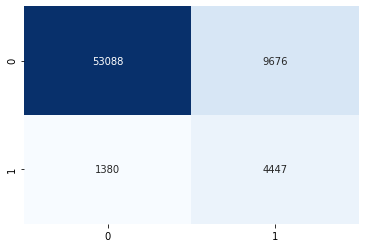

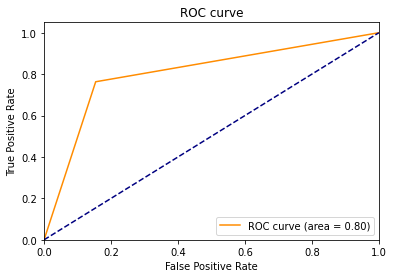

In [15]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = lr.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Now that we have a baseline we'll move to other models.
Starting with Random Forest Classifier.

## Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=seed_value)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

Recall: 74.70%
Precision: 35.08
AUC Score: 0.81
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     62764
           1       0.35      0.75      0.48      5827

    accuracy                           0.86     68591
   macro avg       0.66      0.81      0.70     68591
weighted avg       0.92      0.86      0.88     68591



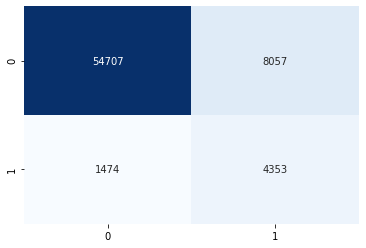

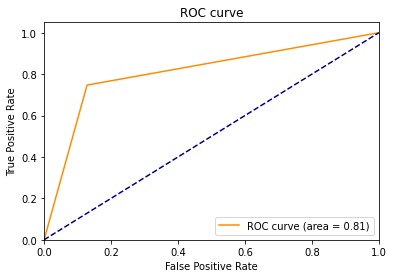

In [17]:
y_pred = rfc.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Using the RFC default parameters the Recall went down 1% while the Precision and AUC went up 4% and 1% respectively.

Which means we get better results from RFC.

Let's compare it to XGBoost

## XGBoost Classifier

In [19]:
import math
#recommended by XGBoost documentation
#scale_pos_weight = count(negative examples)/count(Positive examples)
scale_pos_weight_sqrt = math.sqrt(sum(y_test==0)/sum(y_test==1))#This is useful to limit the effect of a multiplication of positive examples by a very high weight. 
scale_pos_weight = sum(y_test==0)/sum(y_test==1)
scale_pos_weight_sqrt, scale_pos_weight

(3.2819563286858964, 10.771237343401408)

In [25]:
from xgboost import XGBClassifier
scale_pos_weight = round(scale_pos_weight,0)


XGBC = XGBClassifier(n_estimators=750,
                      scale_pos_weight=scale_pos_weight,
                      seed=seed_value,
                      random_state=seed_value)

In [26]:
#the documentation recommends AUC for imbalanced datasets
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["logloss","auc","error"]
%time XGBC.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.57788	validation_0-auc:0.86303	validation_0-error:0.22419	validation_1-logloss:0.74509	validation_1-auc:0.79084	validation_1-error:0.51749
[1]	validation_0-logloss:0.52950	validation_0-auc:0.87495	validation_0-error:0.21828	validation_1-logloss:0.81628	validation_1-auc:0.80060	validation_1-error:0.50954
[2]	validation_0-logloss:0.50470	validation_0-auc:0.90980	validation_0-error:0.23311	validation_1-logloss:0.88334	validation_1-auc:0.83822	validation_1-error:0.54001
[3]	validation_0-logloss:0.49473	validation_0-auc:0.92149	validation_0-error:0.22399	validation_1-logloss:0.95090	validation_1-auc:0.84922	validation_1-error:0.52508
[4]	validation_0-logloss:0.48236	validation_0-auc:0.93153	validation_0-error:0.22248	validation_1-logloss:0.99491	validation_1-auc:0.85954	validation_1-error:0.52637
[5]	validation_0-logloss:0.47345	validation_0-auc:0.94210	validation_0-error:0.21988	validation_1-logloss:1.03050	validation_1-auc:0.86833	validation_1-error:0.52349
[6]	

[50]	validation_0-logloss:0.26949	validation_0-auc:0.98755	validation_0-error:0.11595	validation_1-logloss:0.91374	validation_1-auc:0.90309	validation_1-error:0.34121
[51]	validation_0-logloss:0.26833	validation_0-auc:0.98768	validation_0-error:0.11549	validation_1-logloss:0.91131	validation_1-auc:0.90316	validation_1-error:0.34002
[52]	validation_0-logloss:0.26653	validation_0-auc:0.98779	validation_0-error:0.11459	validation_1-logloss:0.91008	validation_1-auc:0.90328	validation_1-error:0.33822
[53]	validation_0-logloss:0.26400	validation_0-auc:0.98801	validation_0-error:0.11359	validation_1-logloss:0.90592	validation_1-auc:0.90310	validation_1-error:0.33649
[54]	validation_0-logloss:0.26154	validation_0-auc:0.98818	validation_0-error:0.11240	validation_1-logloss:0.90227	validation_1-auc:0.90314	validation_1-error:0.33449
[55]	validation_0-logloss:0.26037	validation_0-auc:0.98828	validation_0-error:0.11175	validation_1-logloss:0.90020	validation_1-auc:0.90322	validation_1-error:0.3333

[100]	validation_0-logloss:0.20184	validation_0-auc:0.99307	validation_0-error:0.08648	validation_1-logloss:0.79397	validation_1-auc:0.90258	validation_1-error:0.28787
[101]	validation_0-logloss:0.20154	validation_0-auc:0.99309	validation_0-error:0.08628	validation_1-logloss:0.79321	validation_1-auc:0.90249	validation_1-error:0.28739
[102]	validation_0-logloss:0.20053	validation_0-auc:0.99319	validation_0-error:0.08600	validation_1-logloss:0.79110	validation_1-auc:0.90252	validation_1-error:0.28709
[103]	validation_0-logloss:0.19920	validation_0-auc:0.99329	validation_0-error:0.08548	validation_1-logloss:0.78818	validation_1-auc:0.90243	validation_1-error:0.28623
[104]	validation_0-logloss:0.19852	validation_0-auc:0.99335	validation_0-error:0.08528	validation_1-logloss:0.78686	validation_1-auc:0.90245	validation_1-error:0.28552
[105]	validation_0-logloss:0.19753	validation_0-auc:0.99342	validation_0-error:0.08479	validation_1-logloss:0.78522	validation_1-auc:0.90260	validation_1-error:

[149]	validation_0-logloss:0.16165	validation_0-auc:0.99574	validation_0-error:0.06797	validation_1-logloss:0.71487	validation_1-auc:0.90290	validation_1-error:0.25484
[150]	validation_0-logloss:0.16138	validation_0-auc:0.99575	validation_0-error:0.06776	validation_1-logloss:0.71472	validation_1-auc:0.90292	validation_1-error:0.25458
[151]	validation_0-logloss:0.15977	validation_0-auc:0.99583	validation_0-error:0.06709	validation_1-logloss:0.71117	validation_1-auc:0.90310	validation_1-error:0.25292
[152]	validation_0-logloss:0.15943	validation_0-auc:0.99586	validation_0-error:0.06698	validation_1-logloss:0.71015	validation_1-auc:0.90306	validation_1-error:0.25292
[153]	validation_0-logloss:0.15918	validation_0-auc:0.99587	validation_0-error:0.06693	validation_1-logloss:0.70965	validation_1-auc:0.90296	validation_1-error:0.25241
[154]	validation_0-logloss:0.15899	validation_0-auc:0.99588	validation_0-error:0.06676	validation_1-logloss:0.70953	validation_1-auc:0.90291	validation_1-error:

[198]	validation_0-logloss:0.13012	validation_0-auc:0.99743	validation_0-error:0.05397	validation_1-logloss:0.64352	validation_1-auc:0.90325	validation_1-error:0.22950
[199]	validation_0-logloss:0.12993	validation_0-auc:0.99745	validation_0-error:0.05389	validation_1-logloss:0.64321	validation_1-auc:0.90322	validation_1-error:0.22940
[200]	validation_0-logloss:0.12955	validation_0-auc:0.99747	validation_0-error:0.05369	validation_1-logloss:0.64289	validation_1-auc:0.90328	validation_1-error:0.22923
[201]	validation_0-logloss:0.12841	validation_0-auc:0.99751	validation_0-error:0.05274	validation_1-logloss:0.64063	validation_1-auc:0.90342	validation_1-error:0.22742
[202]	validation_0-logloss:0.12740	validation_0-auc:0.99755	validation_0-error:0.05225	validation_1-logloss:0.63851	validation_1-auc:0.90351	validation_1-error:0.22657
[203]	validation_0-logloss:0.12631	validation_0-auc:0.99759	validation_0-error:0.05167	validation_1-logloss:0.63621	validation_1-auc:0.90355	validation_1-error:

[247]	validation_0-logloss:0.10110	validation_0-auc:0.99857	validation_0-error:0.04053	validation_1-logloss:0.57578	validation_1-auc:0.90485	validation_1-error:0.20399
[248]	validation_0-logloss:0.10071	validation_0-auc:0.99858	validation_0-error:0.04031	validation_1-logloss:0.57512	validation_1-auc:0.90482	validation_1-error:0.20357
[249]	validation_0-logloss:0.10049	validation_0-auc:0.99858	validation_0-error:0.04029	validation_1-logloss:0.57497	validation_1-auc:0.90487	validation_1-error:0.20339
[250]	validation_0-logloss:0.10035	validation_0-auc:0.99859	validation_0-error:0.04020	validation_1-logloss:0.57480	validation_1-auc:0.90487	validation_1-error:0.20326
[251]	validation_0-logloss:0.10019	validation_0-auc:0.99859	validation_0-error:0.04016	validation_1-logloss:0.57467	validation_1-auc:0.90488	validation_1-error:0.20307
[252]	validation_0-logloss:0.10004	validation_0-auc:0.99860	validation_0-error:0.04008	validation_1-logloss:0.57513	validation_1-auc:0.90499	validation_1-error:

[296]	validation_0-logloss:0.08638	validation_0-auc:0.99898	validation_0-error:0.03382	validation_1-logloss:0.54657	validation_1-auc:0.90570	validation_1-error:0.19017
[297]	validation_0-logloss:0.08620	validation_0-auc:0.99899	validation_0-error:0.03375	validation_1-logloss:0.54631	validation_1-auc:0.90574	validation_1-error:0.19002
[298]	validation_0-logloss:0.08590	validation_0-auc:0.99899	validation_0-error:0.03361	validation_1-logloss:0.54550	validation_1-auc:0.90575	validation_1-error:0.18988
[299]	validation_0-logloss:0.08566	validation_0-auc:0.99900	validation_0-error:0.03346	validation_1-logloss:0.54526	validation_1-auc:0.90585	validation_1-error:0.18987
[300]	validation_0-logloss:0.08544	validation_0-auc:0.99900	validation_0-error:0.03340	validation_1-logloss:0.54490	validation_1-auc:0.90588	validation_1-error:0.18960
[301]	validation_0-logloss:0.08514	validation_0-auc:0.99901	validation_0-error:0.03330	validation_1-logloss:0.54462	validation_1-auc:0.90593	validation_1-error:

[345]	validation_0-logloss:0.07615	validation_0-auc:0.99923	validation_0-error:0.02902	validation_1-logloss:0.53081	validation_1-auc:0.90631	validation_1-error:0.18243
[346]	validation_0-logloss:0.07602	validation_0-auc:0.99923	validation_0-error:0.02894	validation_1-logloss:0.53050	validation_1-auc:0.90629	validation_1-error:0.18237
[347]	validation_0-logloss:0.07586	validation_0-auc:0.99924	validation_0-error:0.02886	validation_1-logloss:0.53039	validation_1-auc:0.90634	validation_1-error:0.18231
[348]	validation_0-logloss:0.07575	validation_0-auc:0.99924	validation_0-error:0.02880	validation_1-logloss:0.53028	validation_1-auc:0.90633	validation_1-error:0.18214
[349]	validation_0-logloss:0.07561	validation_0-auc:0.99924	validation_0-error:0.02877	validation_1-logloss:0.53019	validation_1-auc:0.90634	validation_1-error:0.18195
[350]	validation_0-logloss:0.07521	validation_0-auc:0.99925	validation_0-error:0.02860	validation_1-logloss:0.52862	validation_1-auc:0.90634	validation_1-error:

[394]	validation_0-logloss:0.06844	validation_0-auc:0.99940	validation_0-error:0.02578	validation_1-logloss:0.51804	validation_1-auc:0.90623	validation_1-error:0.17658
[395]	validation_0-logloss:0.06810	validation_0-auc:0.99941	validation_0-error:0.02560	validation_1-logloss:0.51700	validation_1-auc:0.90623	validation_1-error:0.17612
[396]	validation_0-logloss:0.06791	validation_0-auc:0.99941	validation_0-error:0.02554	validation_1-logloss:0.51671	validation_1-auc:0.90620	validation_1-error:0.17596
[397]	validation_0-logloss:0.06783	validation_0-auc:0.99941	validation_0-error:0.02546	validation_1-logloss:0.51684	validation_1-auc:0.90616	validation_1-error:0.17590
[398]	validation_0-logloss:0.06779	validation_0-auc:0.99941	validation_0-error:0.02545	validation_1-logloss:0.51679	validation_1-auc:0.90620	validation_1-error:0.17585
[399]	validation_0-logloss:0.06765	validation_0-auc:0.99942	validation_0-error:0.02540	validation_1-logloss:0.51659	validation_1-auc:0.90621	validation_1-error:

[443]	validation_0-logloss:0.06183	validation_0-auc:0.99952	validation_0-error:0.02269	validation_1-logloss:0.50914	validation_1-auc:0.90636	validation_1-error:0.16999
[444]	validation_0-logloss:0.06178	validation_0-auc:0.99952	validation_0-error:0.02266	validation_1-logloss:0.50920	validation_1-auc:0.90636	validation_1-error:0.16995
[445]	validation_0-logloss:0.06172	validation_0-auc:0.99952	validation_0-error:0.02263	validation_1-logloss:0.50934	validation_1-auc:0.90640	validation_1-error:0.16972
[446]	validation_0-logloss:0.06155	validation_0-auc:0.99953	validation_0-error:0.02259	validation_1-logloss:0.50869	validation_1-auc:0.90635	validation_1-error:0.16975
[447]	validation_0-logloss:0.06141	validation_0-auc:0.99953	validation_0-error:0.02254	validation_1-logloss:0.50842	validation_1-auc:0.90638	validation_1-error:0.16972
[448]	validation_0-logloss:0.06126	validation_0-auc:0.99953	validation_0-error:0.02249	validation_1-logloss:0.50820	validation_1-auc:0.90634	validation_1-error:

[492]	validation_0-logloss:0.05661	validation_0-auc:0.99961	validation_0-error:0.02056	validation_1-logloss:0.50322	validation_1-auc:0.90636	validation_1-error:0.16654
[493]	validation_0-logloss:0.05655	validation_0-auc:0.99961	validation_0-error:0.02055	validation_1-logloss:0.50310	validation_1-auc:0.90636	validation_1-error:0.16636
[494]	validation_0-logloss:0.05645	validation_0-auc:0.99961	validation_0-error:0.02052	validation_1-logloss:0.50298	validation_1-auc:0.90636	validation_1-error:0.16638
[495]	validation_0-logloss:0.05635	validation_0-auc:0.99961	validation_0-error:0.02048	validation_1-logloss:0.50284	validation_1-auc:0.90633	validation_1-error:0.16631
[496]	validation_0-logloss:0.05627	validation_0-auc:0.99962	validation_0-error:0.02045	validation_1-logloss:0.50274	validation_1-auc:0.90634	validation_1-error:0.16638
[497]	validation_0-logloss:0.05619	validation_0-auc:0.99962	validation_0-error:0.02044	validation_1-logloss:0.50275	validation_1-auc:0.90629	validation_1-error:

[541]	validation_0-logloss:0.05199	validation_0-auc:0.99968	validation_0-error:0.01870	validation_1-logloss:0.49739	validation_1-auc:0.90639	validation_1-error:0.16275
[542]	validation_0-logloss:0.05184	validation_0-auc:0.99968	validation_0-error:0.01865	validation_1-logloss:0.49719	validation_1-auc:0.90640	validation_1-error:0.16270
[543]	validation_0-logloss:0.05174	validation_0-auc:0.99968	validation_0-error:0.01859	validation_1-logloss:0.49700	validation_1-auc:0.90643	validation_1-error:0.16254
[544]	validation_0-logloss:0.05160	validation_0-auc:0.99969	validation_0-error:0.01851	validation_1-logloss:0.49679	validation_1-auc:0.90638	validation_1-error:0.16265
[545]	validation_0-logloss:0.05146	validation_0-auc:0.99969	validation_0-error:0.01840	validation_1-logloss:0.49644	validation_1-auc:0.90638	validation_1-error:0.16254
[546]	validation_0-logloss:0.05132	validation_0-auc:0.99969	validation_0-error:0.01841	validation_1-logloss:0.49639	validation_1-auc:0.90637	validation_1-error:

[590]	validation_0-logloss:0.04761	validation_0-auc:0.99974	validation_0-error:0.01674	validation_1-logloss:0.49392	validation_1-auc:0.90634	validation_1-error:0.15939
[591]	validation_0-logloss:0.04756	validation_0-auc:0.99974	validation_0-error:0.01671	validation_1-logloss:0.49396	validation_1-auc:0.90632	validation_1-error:0.15939
[592]	validation_0-logloss:0.04747	validation_0-auc:0.99974	validation_0-error:0.01668	validation_1-logloss:0.49395	validation_1-auc:0.90630	validation_1-error:0.15939
[593]	validation_0-logloss:0.04738	validation_0-auc:0.99974	validation_0-error:0.01667	validation_1-logloss:0.49360	validation_1-auc:0.90631	validation_1-error:0.15942
[594]	validation_0-logloss:0.04726	validation_0-auc:0.99974	validation_0-error:0.01660	validation_1-logloss:0.49347	validation_1-auc:0.90628	validation_1-error:0.15934
[595]	validation_0-logloss:0.04719	validation_0-auc:0.99974	validation_0-error:0.01657	validation_1-logloss:0.49334	validation_1-auc:0.90630	validation_1-error:

[639]	validation_0-logloss:0.04394	validation_0-auc:0.99978	validation_0-error:0.01528	validation_1-logloss:0.49237	validation_1-auc:0.90614	validation_1-error:0.15715
[640]	validation_0-logloss:0.04386	validation_0-auc:0.99978	validation_0-error:0.01524	validation_1-logloss:0.49220	validation_1-auc:0.90620	validation_1-error:0.15709
[641]	validation_0-logloss:0.04380	validation_0-auc:0.99978	validation_0-error:0.01524	validation_1-logloss:0.49204	validation_1-auc:0.90618	validation_1-error:0.15708
[642]	validation_0-logloss:0.04369	validation_0-auc:0.99979	validation_0-error:0.01520	validation_1-logloss:0.49173	validation_1-auc:0.90619	validation_1-error:0.15696
[643]	validation_0-logloss:0.04363	validation_0-auc:0.99979	validation_0-error:0.01513	validation_1-logloss:0.49199	validation_1-auc:0.90619	validation_1-error:0.15684
[644]	validation_0-logloss:0.04358	validation_0-auc:0.99979	validation_0-error:0.01515	validation_1-logloss:0.49202	validation_1-auc:0.90619	validation_1-error:

[688]	validation_0-logloss:0.04040	validation_0-auc:0.99982	validation_0-error:0.01391	validation_1-logloss:0.49069	validation_1-auc:0.90600	validation_1-error:0.15467
[689]	validation_0-logloss:0.04031	validation_0-auc:0.99982	validation_0-error:0.01386	validation_1-logloss:0.49023	validation_1-auc:0.90599	validation_1-error:0.15460
[690]	validation_0-logloss:0.04029	validation_0-auc:0.99982	validation_0-error:0.01384	validation_1-logloss:0.49070	validation_1-auc:0.90602	validation_1-error:0.15463
[691]	validation_0-logloss:0.04021	validation_0-auc:0.99982	validation_0-error:0.01379	validation_1-logloss:0.49071	validation_1-auc:0.90600	validation_1-error:0.15436
[692]	validation_0-logloss:0.04014	validation_0-auc:0.99982	validation_0-error:0.01379	validation_1-logloss:0.49072	validation_1-auc:0.90600	validation_1-error:0.15438
[693]	validation_0-logloss:0.04012	validation_0-auc:0.99982	validation_0-error:0.01381	validation_1-logloss:0.49062	validation_1-auc:0.90600	validation_1-error:

[737]	validation_0-logloss:0.03759	validation_0-auc:0.99985	validation_0-error:0.01266	validation_1-logloss:0.49001	validation_1-auc:0.90580	validation_1-error:0.15259
[738]	validation_0-logloss:0.03754	validation_0-auc:0.99985	validation_0-error:0.01263	validation_1-logloss:0.48989	validation_1-auc:0.90580	validation_1-error:0.15244
[739]	validation_0-logloss:0.03746	validation_0-auc:0.99985	validation_0-error:0.01256	validation_1-logloss:0.48978	validation_1-auc:0.90580	validation_1-error:0.15237
[740]	validation_0-logloss:0.03744	validation_0-auc:0.99985	validation_0-error:0.01255	validation_1-logloss:0.48970	validation_1-auc:0.90581	validation_1-error:0.15243
[741]	validation_0-logloss:0.03740	validation_0-auc:0.99985	validation_0-error:0.01254	validation_1-logloss:0.48966	validation_1-auc:0.90582	validation_1-error:0.15234
[742]	validation_0-logloss:0.03734	validation_0-auc:0.99985	validation_0-error:0.01253	validation_1-logloss:0.48971	validation_1-auc:0.90585	validation_1-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.0, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Recall: 79.51%
Precision: 33.40
AUC Score: 0.82
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     62764
           1       0.33      0.80      0.47      5827

    accuracy                           0.85     68591
   macro avg       0.66      0.82      0.69     68591
weighted avg       0.92      0.85      0.87     68591



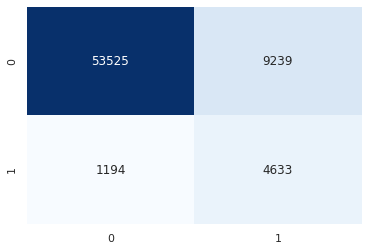

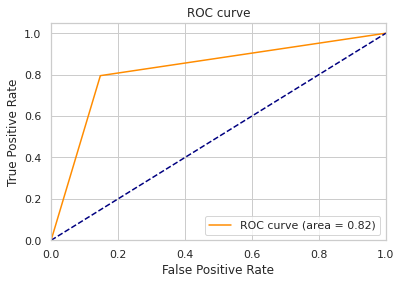

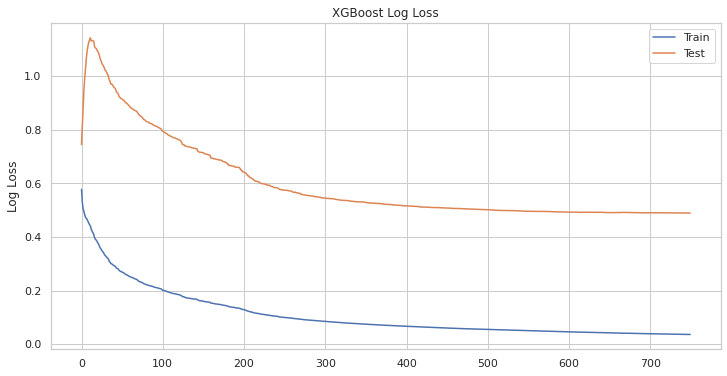

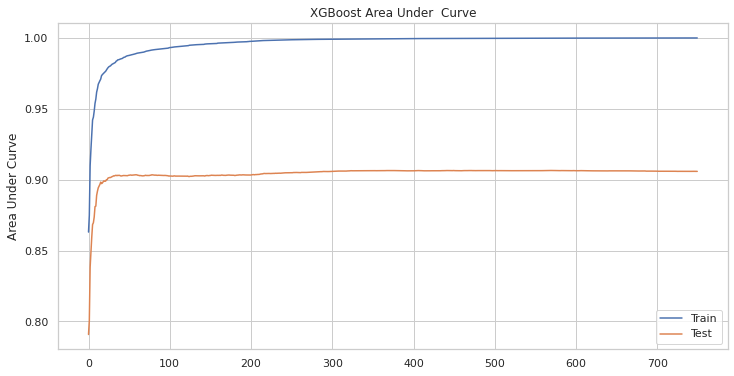

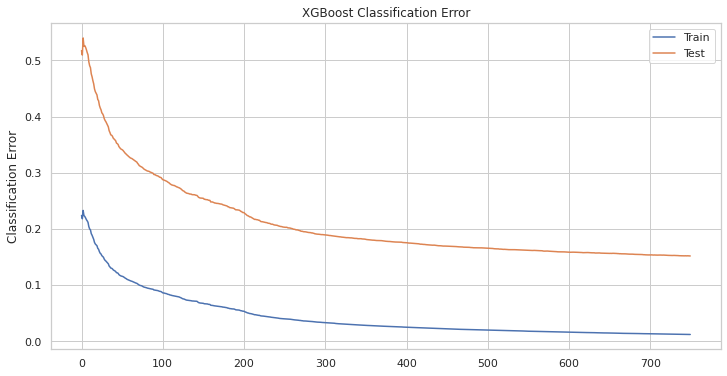

In [28]:
y_pred = XGBC.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

sns.set(style="whitegrid")
sns.set_color_codes("muted")
results = XGBC.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Area Under Curve')
plt.title('XGBoost Area Under  Curve')
plt.show()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

## Summary

In [29]:
summary = pd.DataFrame(np.array([[76.32, 31.49, 0.80], [74.70, 35.08, 0.81], [79.51, 33.40, 0.82]]), 
                       index=['Logistic Regression','Random Forest', 'XGB Classifier'],
                       columns=['Recall', 'Precision', 'AUC Score'])

summary



,Recall,Precision,AUC Score
Logistic Regression,76.32,31.49,0.80
Random Forest,74.70,35.08,0.81
XGB Classifier,79.51,33.40,0.82


Overall XGB predicts correctly more (AUC = 82).

But now what weights more going forward is what we are most interested in predicting more accurately or which incorrect prediction weights the most:
* people under 50K
* people over 50k
* or both

Since we focused the metrics on the minority class we will chose XGB as the model as it has the highest Recall and AUC.

Now a feature weight analysis with XGB will be performed in the feature exploration notebook.